In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
df=pd.read_csv("269_temp.csv")

In [4]:
df.head()

,Date,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
0,1/15/2020 1:44,69.3,66.71,68,1/14/2020 1:44,68.8,1/13/2020 1:44,70.4
1,1/15/2020 3:44,69.8,66.14,66,1/14/2020 3:44,69.2,1/13/2020 3:44,70.4
2,1/15/2020 5:44,70.1,65.81,68,1/14/2020 5:44,69.6,1/13/2020 5:44,70.4
3,1/15/2020 7:44,68.0,67.14,72,1/14/2020 7:44,67.6,1/13/2020 7:44,69.8
4,1/15/2020 9:44,67.6,66.77,75,1/14/2020 9:44,66.0,1/13/2020 9:44,67.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 8 columns):
Date                           384 non-null object
Temperature                    384 non-null float64
Humidity                       384 non-null float64
Outside Temperature            384 non-null int64
Previous Date                  384 non-null object
Temperature on Previous day    384 non-null float64
2 days before Date             384 non-null object
Temperature 2 days before      384 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 24.1+ KB


In [6]:
#df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [7]:
df.head()

,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
Date,,,,,,,
2020-01-15 01:44:00,69.3,66.71,68,1/14/2020 1:44,68.8,1/13/2020 1:44,70.4
2020-01-15 03:44:00,69.8,66.14,66,1/14/2020 3:44,69.2,1/13/2020 3:44,70.4
2020-01-15 05:44:00,70.1,65.81,68,1/14/2020 5:44,69.6,1/13/2020 5:44,70.4
2020-01-15 07:44:00,68.0,67.14,72,1/14/2020 7:44,67.6,1/13/2020 7:44,69.8
2020-01-15 09:44:00,67.6,66.77,75,1/14/2020 9:44,66.0,1/13/2020 9:44,67.9


In [8]:
df.dropna(inplace=True)

In [9]:
ts=df.loc['1/15/2020':'2/15/2020',['Temperature','Humidity','Outside Temperature','Temperature on Previous day','Temperature 2 days before']]
#ts=pd.concat([df.loc['1/20/2020':'1/24/2020'],df.loc['1/27/2020':'1/31/2020']])[['Temperature','Humidity','Outside Temperature','Temperature on Previous day','Temperature 2 days before']]
ts.head()

,Temperature,Humidity,Outside Temperature,Temperature on Previous day,Temperature 2 days before
Date,,,,,
2020-01-15 01:44:00,69.3,66.71,68,68.8,70.4
2020-01-15 03:44:00,69.8,66.14,66,69.2,70.4
2020-01-15 05:44:00,70.1,65.81,68,69.6,70.4
2020-01-15 07:44:00,68.0,67.14,72,67.6,69.8
2020-01-15 09:44:00,67.6,66.77,75,66.0,67.9


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


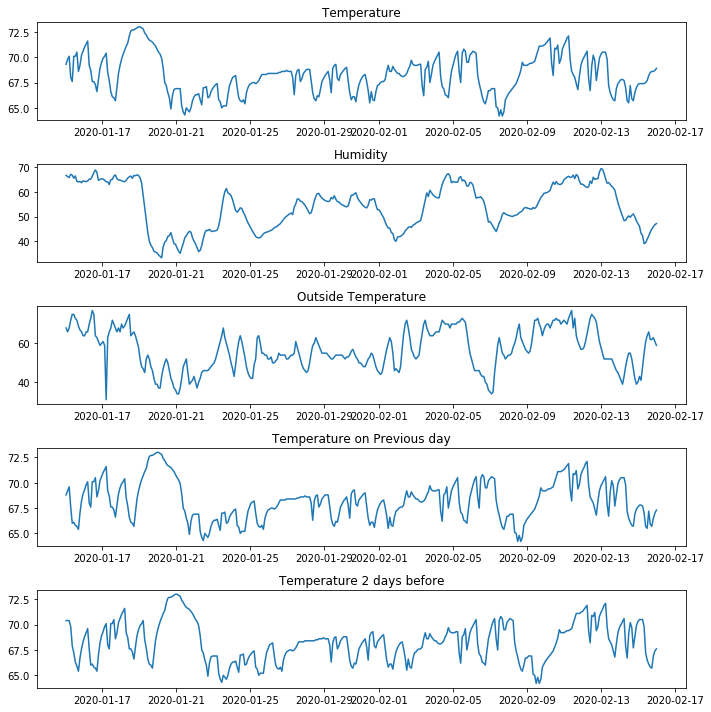

In [10]:
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(10,10))
ax1.plot(ts['Temperature'])
ax1.set_title('Temperature')
ax2.plot(ts['Humidity'])
ax2.set_title('Humidity')
ax3.plot(ts['Outside Temperature'])
ax3.set_title('Outside Temperature')
ax4.plot(ts['Temperature on Previous day'])
ax4.set_title('Temperature on Previous day')
ax5.plot(ts['Temperature 2 days before'])
ax5.set_title('Temperature 2 days before')
plt.tight_layout()

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
grangers_causation_matrix(ts,ts.columns)

,Temperature_x,Humidity_x,Outside Temperature_x,Temperature on Previous day_x,Temperature 2 days before_x
Temperature_y,1.0000,0.0005,0.0,0.0000,0.0005
Humidity_y,0.0000,1.0000,0.0,0.0000,0.0007
Outside Temperature_y,0.0002,0.0043,1.0,0.0005,0.0001
Temperature on Previous day_y,0.0000,0.0000,0.0,1.0000,0.0000
Temperature 2 days before_y,0.0000,0.0000,0.0,0.0000,1.0000


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [14]:
cointegration_test(ts)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Temperature ::  162.04    > 60.0627   =>   True
Humidity ::  100.23    > 40.1749   =>   True
Outside Temperature ::  53.6      > 24.2761   =>   True
Temperature on Previous day ::  11.46     > 12.3212   =>   False
Temperature 2 days before ::  0.0       > 4.1296    =>   False


In [15]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 384 entries, 2020-01-15 01:44:00 to 2020-02-15 23:44:00
Data columns (total 5 columns):
Temperature                    384 non-null float64
Humidity                       384 non-null float64
Outside Temperature            384 non-null int64
Temperature on Previous day    384 non-null float64
Temperature 2 days before      384 non-null float64
dtypes: float64(4), int64(1)
memory usage: 18.0 KB


In [16]:
nobs = 96
ts_train, ts_test = ts[0:-nobs], ts[-nobs:]

# Check size
print(ts_train.shape) 
print(ts_test.shape)  

(288, 5)
(96, 5)


In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [18]:
for name, column in ts_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5707
 No. Lags Chosen       = 12
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0063. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8695
 No. Lags Chosen       = 14
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.049. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Outside Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

In [19]:
ts_differenced = ts_train.diff().dropna()

In [20]:
ts_differenced.head()

,Temperature,Humidity,Outside Temperature,Temperature on Previous day,Temperature 2 days before
Date,,,,,
2020-01-15 03:44:00,0.5,-0.57,-2.0,0.4,0.0
2020-01-15 05:44:00,0.3,-0.33,2.0,0.4,0.0
2020-01-15 07:44:00,-2.1,1.33,4.0,-2.0,-0.6
2020-01-15 09:44:00,-0.4,-0.37,3.0,-1.6,-1.9
2020-01-15 11:44:00,2.5,-1.25,0.0,0.1,-0.7


In [21]:
for name, column in ts_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7024
 No. Lags Chosen       = 12
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2959
 No. Lags Chosen       = 13
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0005. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Outside Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [22]:
model = VAR(ts_differenced)
x = model.select_order(maxlags=20)
x.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,1.247,1.315,3.481,1.274
1,0.6089,1.012,1.838,0.7708
2,0.5698,1.309,1.768,0.8666
3,0.5880,1.663,1.802,1.020
4,0.6056,2.016,1.835,1.172
5,0.6290,2.376,1.882,1.331
6,0.2648,2.347,1.310,1.101
7,0.2857,2.704,1.342,1.257
8,0.3461,3.100,1.431,1.452
9,0.3549,3.445,1.451,1.596


In [23]:
model_fitted = model.fit(13)
model_fitted.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, May, 2020
Time:                     20:35:16
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -128.381
Nobs:                     274.000    HQIC:                  -130.986
Log likelihood:           16570.4    FPE:                2.37630e-58
AIC:                     -132.733    Det(Omega_mle):     8.07719e-59
--------------------------------------------------------------------
Results for equation Temperature
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                       -0.005002         0.038323           -0.131           0.896
L1.Temperature                               0.089720         0.04

In [24]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(ts.columns, out):
    print(col, ':', round(val, 2))

Temperature : 2.04
Humidity : 2.02
Outside Temperature : 2.0
Temperature on Previous day : 1.33
Temperature 2 days before : 1.43


In [25]:
lag_order = model_fitted.k_ar
print(lag_order)

13


In [26]:
forecast_input = ts_differenced.values[-lag_order:]
forecast_input

array([[ 0.  ,  0.21, -1.  ,  0.2 ,  0.6 ],
       [ 0.2 , -0.91, -1.  ,  0.2 ,  0.6 ],
       [ 0.  , -1.11,  1.  , -0.1 ,  0.5 ],
       [ 0.  , -0.99, 10.  , -0.1 ,  0.3 ],
       [-1.8 , -1.02,  7.  , -2.1 , -2.  ],
       [-0.1 ,  1.59,  7.  , -0.9 , -1.1 ],
       [-0.8 ,  1.95,  4.  , -0.6 ,  2.9 ],
       [ 0.6 ,  1.12, -4.  , -0.7 ,  0.4 ],
       [-0.6 ,  2.25, -4.  , -0.5 , -0.2 ],
       [ 0.4 ,  0.72, -1.  , -0.2 , -1.1 ],
       [ 1.2 , -0.51, -2.  ,  0.6 ,  0.  ],
       [ 0.3 , -0.34,  1.  ,  0.7 ,  0.7 ],
       [ 0.3 , -0.21,  1.  ,  0.  ,  0.2 ]])

In [27]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ts_forecast = pd.DataFrame(fc, index=ts.index[-nobs:], columns=ts.columns + '_1d')
ts_forecast.shape

(96, 5)

In [28]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [29]:
ts_results = invert_transformation(ts_train,ts_forecast, second_diff=False)
ts_results.loc[:,['Temperature_forecast', 'Humidity_forecast', 'Outside Temperature_forecast','Temperature on Previous day_forecast','Temperature 2 days before_forecast']]        

,Temperature_forecast,Humidity_forecast,Outside Temperature_forecast,Temperature on Previous day_forecast,Temperature 2 days before_forecast
Date,,,,,
2020-02-08 01:44:00,66.488011,51.031216,54.570404,66.900000,70.600000
2020-02-08 03:44:00,67.294957,50.969387,56.024750,66.900000,70.500000
2020-02-08 05:44:00,67.385944,50.840903,55.916000,66.900000,70.400000
2020-02-08 07:44:00,67.087973,51.284676,62.065750,65.100000,68.300000
2020-02-08 09:44:00,67.101890,52.885750,62.513016,65.000000,67.400000
2020-02-08 11:44:00,67.504733,53.101525,64.533859,64.200000,66.800000
2020-02-08 13:44:00,67.785128,52.967614,62.821945,64.800000,66.100000
2020-02-08 15:44:00,67.196048,53.289513,60.653000,64.200000,65.600000
2020-02-08 17:44:00,67.329837,53.499474,59.403000,64.600000,65.400000


In [30]:
# fig, axes = plt.subplots(nrows=int(len(ts.columns)/2), ncols=2, dpi=150, figsize=(10,10))
# for i, (col,ax) in enumerate(zip(ts.columns, axes.flatten())):
#     ts_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#     ts_test[col][-nobs:].plot(legend=True, ax=ax);
#     ax.set_title(col + ": Forecast vs Actuals")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

# plt.tight_layout();

Text(0, 0.5, 'Temperature (F)')

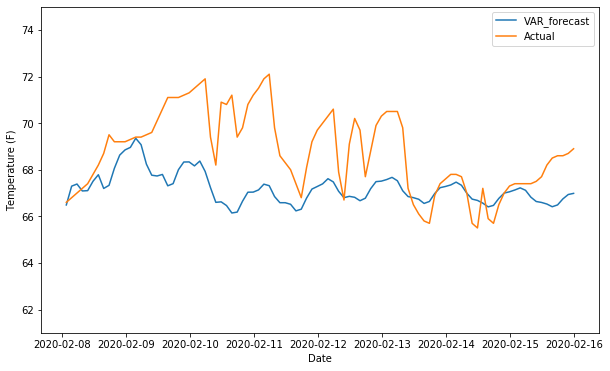

In [31]:
fig= plt.figure(figsize=(10,6))
plt.plot(ts_results['Temperature_forecast'],label='VAR_forecast')
#plt.plot(ts_forecast['Temperature_1d'],label='VAR_forecast')
plt.plot(ts_test['Temperature'],label='Actual')
plt.legend(loc="upper right")
plt.ylim(61,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

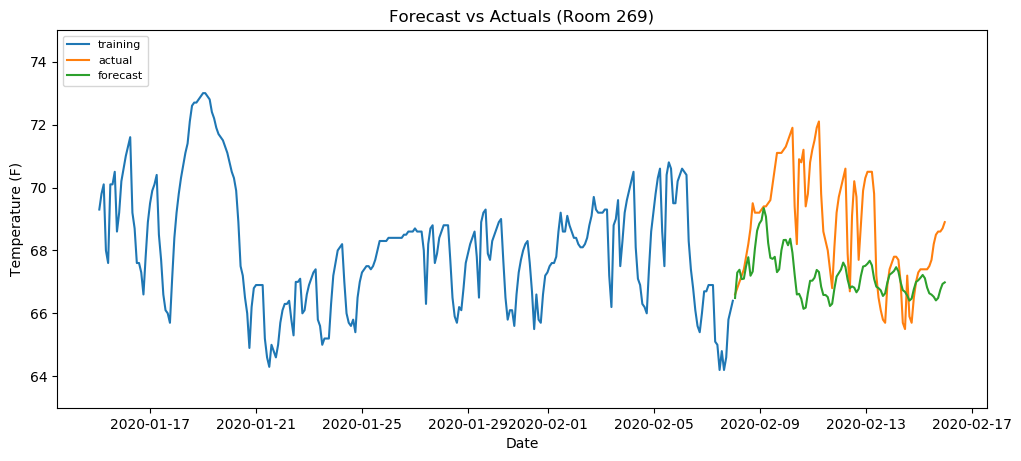

In [32]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts_train['Temperature'], label='training')
plt.plot(ts_test['Temperature'], label='actual')
#plt.plot(ts_forecast['Temperature_1d'], label='forecast')
plt.plot(ts_results['Temperature_forecast'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 269)')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.ylim(63,75)
plt.show()

In [33]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [34]:
print('Forecast Accuracy of: Temperature')
accuracy_prod = forecast_accuracy(ts_results['Temperature_forecast'].values, ts_test['Temperature'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Temperature
mape :  0.0248
me :  -1.5751
mae :  1.7303
mpe :  -0.0224
rmse :  2.2053
corr :  0.4379
minmax :  0.0247


In [35]:
# print('Forecast Accuracy of: Temperature')
# accuracy_prod = forecast_accuracy(ts_forecast['Temperature_1d'].values, ts_test['Temperature'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))